# RandomForest Results

This notebook makes up the data for the result section of the paper.

## Loading the data

In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import preprocessing, metrics
import scikitplot as skplt
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import pickle
from sklearn.tree import DecisionTreeClassifier
from tsai.all import *
from sklearn.model_selection import validation_curve
import numpy as np

We drop `not_defined` behaviours. 
In addition, we merge the following behaviours accordingly:

  * `back_preening` and `front_preening` as `preening`
  * `standing_shaking` and `scratch_with_feet` as `standing`
  * `body_pump` and `feather_clapping` as `fluffing`
  
  
Merging even bigger classes (e.g. `standing` and `walking` as `background`) has shown to be counter-productive, since it makes interpreting the results even more complicated, because of problems arising from huge imbalances. 

Number of frames: 10424241
Number of frames after dropping non-labelled frames: 865548


<AxesSubplot:title={'center':'Frames per behavior'}>

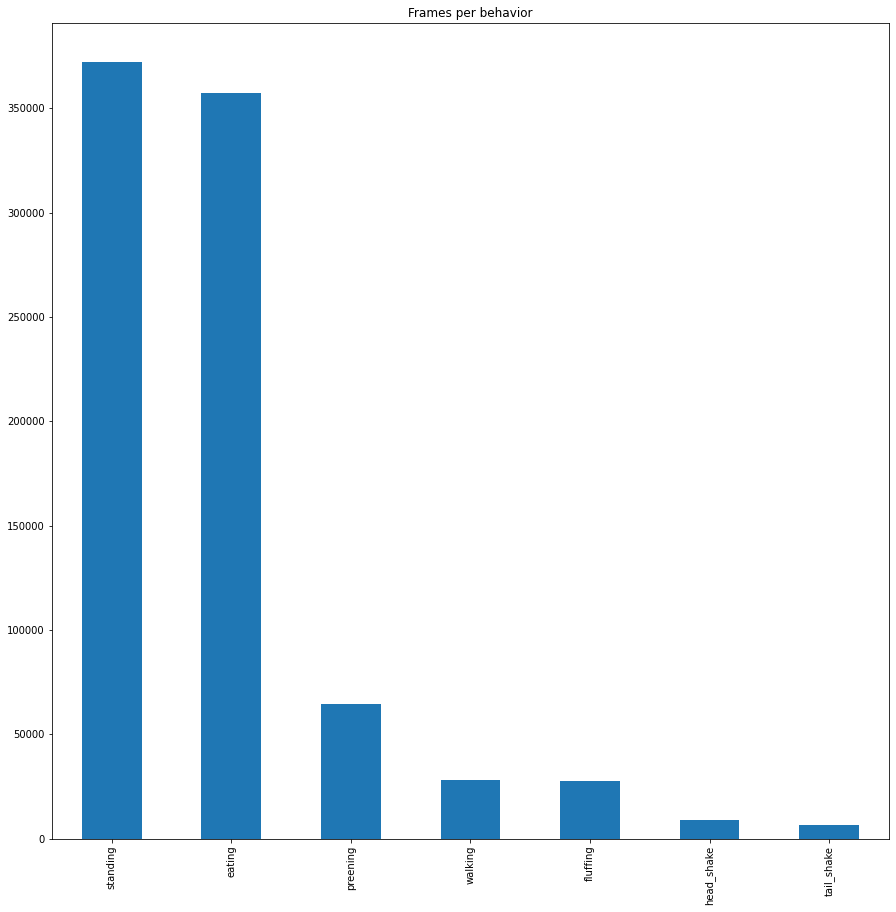

In [2]:
df = pd.read_hdf("merged_20210405.h5")
print(f"Number of frames: {len(df)}")
df = df[(df['behavior'] != "not_defined")]
print(f"Number of frames after dropping non-labelled frames: {len(df)}")

df.loc[(df['behavior'] == "back_preening") | (df['behavior'] == "front_preening"), 'behavior'] = "preening"
df.loc[(df['behavior'] == "standing_shaking") | (df['behavior'] == "scratch_with_feet"), 'behavior'] = "standing"
df.loc[(df['behavior'] == "body_pump") | (df['behavior'] == "feather_clapping"), 'behavior'] = "fluffing"

df.behavior.value_counts().plot(kind='bar', figsize=(15,15), title='Frames per behavior')

We use all bodypoint with high continously high likelihood as features. 
Mainly we don't use the beak because of general fluctuating visibility.

In [26]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]

y = df['behavior']
x = df[features].values

## Validation and Learning Curve

In order to better report the performance of our models, we want to plot the [validation and the learning curves](https://scikit-learn.org/stable/modules/learning_curve.html), something which is also reported in other papers.

### Validation Curve

The validation curve can be used to find optimal hyperparameters. In our case, we check for the number of decision trees in the forest.

In [16]:
loaded = None
try:
    loaded = np.load("randomForest_validationCurve.npz")
    train_scores = loaded['arr_0']
    train_scores_std = loaded['arr_1']
    test_scores_mean = loaded['arr_2']
    test_scores_std = loaded['arr_3']
    param_range = loaded['arr_4']
    
    train_scores_mean = np.mean(train_scores, axis=1) # this is from a bug, that we forgot to save this below
    
    print("loaded existing validation curve data")
except FileNotFoundError:
    print("no existing validation curve data")
    
if not loaded:
    print("Calculating validation curve, this can take many hours (up to 24)!!!")
    param_range = list(range(1, 101)) # this could be optimized to calculate less redundant trees with hyperparemters close to each other, e.g. spread the values
    train_scores, test_scores = validation_curve(
        RandomForestClassifier(), x, y, param_name="n_estimators", param_range=param_range, # TODO: configure to use balanced class weights
        scoring="f1_weighted", n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    np.savez("randomForest_validationCurve.npz", train_scores, train_scores_std, test_scores_mean, test_scores_std, param_range)

loaded existing validation curve data


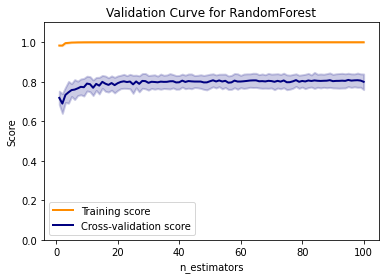

In [17]:
plt.title("Validation Curve for RandomForest")
plt.xlabel(r"n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

From this plot we can see, that we get a good cross-validation score for a relatively small an `n~=20`. 
In order to improve computational efficieny (for fitting as well as for prediction), we can therefore select `n` accordingly.

In [21]:
n = 19 # off by one, since we generate param_range for (1, 100) as inclusive interval
print(f"cross-val score for n_estimators={param_range[n]} is {test_scores_mean[n]}")

max_score_index = np.argmax(test_scores_mean)
print(f"maximum cross-val score for n_estimators={param_range[max_score_index]} is {test_scores_mean[max_score_index]}")

cross-val score for n_estimators=20 is 0.7928431400463518
maximum cross-val score for n_estimators=95 is 0.8092528725144863


### Learning Curve

The learning curve tells us how much training data is necessary for a good performing model. Code was taken from [examples/model_selection/plot_learning_curve.py](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py).
Since we have seen that `n_estimators=20` is a sufficiently good hyperparameter, we will set it to this value for the further analyzes.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring="f1_weighted")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

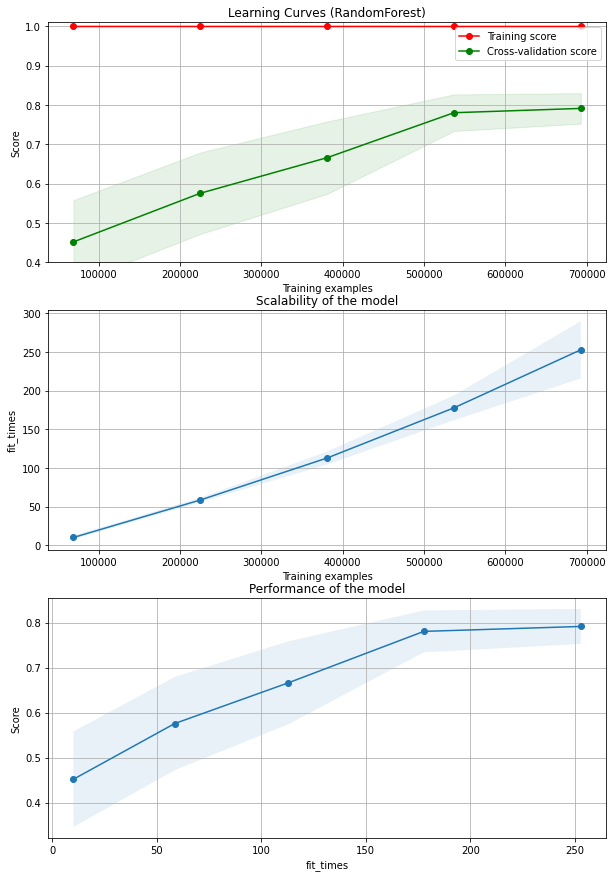

In [29]:
fig, axes = plt.subplots(3,1, figsize=(10, 15))

title = "Learning Curves (RandomForest)"
estimator = RandomForestClassifier(n_estimators=20) # todo: balanced class weights
plot_learning_curve(estimator, title, x, y, axes=axes, ylim=(0.4, 1.01), n_jobs=-1)

plt.show()

In our case, the more training data we have, the better the cross-val-score becomes. 
And as fundamentally better, that we should currently use as much data, as we can. 
But also note, that we achieve a good performance with 77.5% of used training data as well.

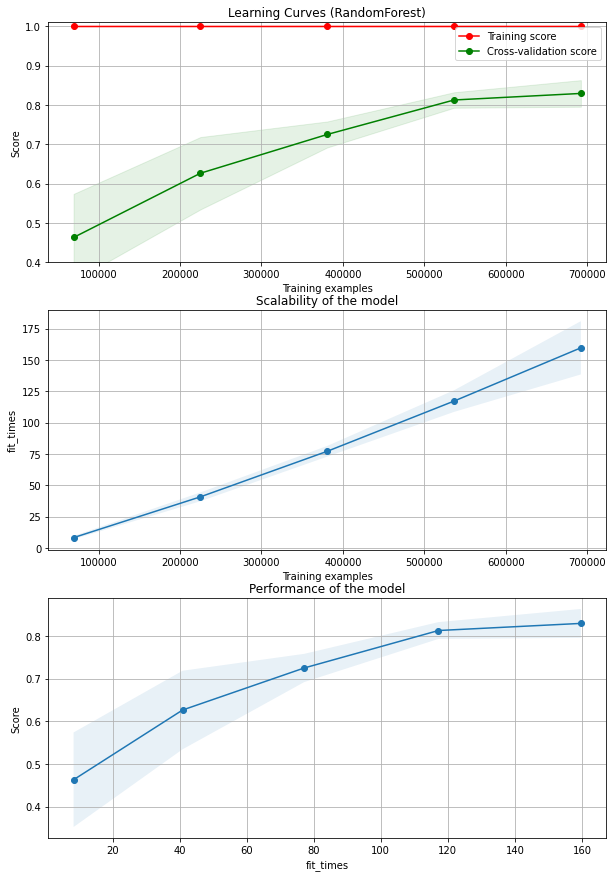

In [28]:
fig, axes = plt.subplots(3,1, figsize=(10, 15))

title = "Learning Curves (RandomForest)"
estimator = RandomForestClassifier(n_estimators=20, class_weight='balanced')
plot_learning_curve(estimator, title, x, y, axes=axes, ylim=(0.4, 1.01), n_jobs=-1)

plt.show()

## Time series vs. single frame

The size of the time series windows can be considered a hyperparameter of our approach. Therefore, we are interested in the validation curve for this parameter.

### Validation Curve

In [46]:
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

def create_ts(window_size, df):
    
    file_name = f"ts_windows_{window_size}.npz"
    loaded = None
    try:
        loaded = np.load(file_name, allow_pickle=True)
        x_ts = loaded['arr_0']
        y_ts = loaded['arr_1']
        
        print(f"loaded existing timeseries data for window size {window_size}")
    except FileNotFoundError:
        print(f"no existing timeseries data for window size {window_size}")
        
    if not loaded:
        def y_func(o): 
            return scipy.stats.mode(o, axis=1).mode.ravel()

        x_ts, y_ts = SlidingWindow(window_size, get_x=features, get_y='behavior', y_func=y_func)(df)
        x_ts = x_ts.reshape((-1, x_ts.shape[1] * x_ts.shape[2]))
        np.savez(file_name, x_ts, y_ts)
        
    return x_ts, y_ts

def cross_val_rf(window_size, df):
    # TODO: make each score cacheable
    
    x, y = create_ts(window_size, df)
    
    train_scores = []
    cross_val_scores = []
    
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(random_state=0, n_estimators=20, n_jobs=-1)
        clf.fit(x_train, y_train)
        
        y_pred_train = clf.predict(x_train)
        y_pred_test = clf.predict(x_test)
        
        f1_train = f1_score(y_train, y_pred_train, average='weighted')
        f1_test = f1_score(y_test, y_pred_test, average='weighted')
        
        train_scores.append(f1_train)
        cross_val_scores.append(f1_test)
        
    return train_scores, cross_val_scores

In [ ]:
train_scores = []
test_scores = []

param_range = [1, 2, 4, 8, 16, 32, 64]

for window_size in tqdm(param_range):
    train_score, test_score = cross_val_rf(window_size, df)
    train_scores.append(train_score)
    test_scores.append(test_score)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve for RandomForest No. of Frames in Windows")
plt.xlabel(r"No. of Frames in Windows")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [7]:
np.savez("randomForest_window_size_validation.npz", train_scores, test_scores, param_range)

In [4]:
loaded = np.load("randomForest_window_size_validation.npz", allow_pickle=True)
test_scores = loaded['arr_1']

In [5]:
test_scores

array([[0.82242011, 0.81811098, 0.70213174, 0.85257617, 0.84169819],
       [0.80014732, 0.81534486, 0.72952849, 0.85197075, 0.83589635],
       [0.81815384, 0.82160744, 0.74124839, 0.8582253 , 0.8284203 ],
       [0.84628064, 0.82321821, 0.75464591, 0.85366494, 0.85638453],
       [0.83757175, 0.82436682, 0.78371535, 0.85598269, 0.87655883],
       [0.87111908, 0.84237438, 0.79294933, 0.86321298, 0.88314295],
       [0.89583289, 0.84216929, 0.77390802, 0.86582381, 0.88182301]])

In [6]:
print(np.mean(test_scores, axis=1))
print(np.std(test_scores, axis=1))

[0.80738744 0.80657755 0.81353105 0.82683885 0.83563909 0.85055974
 0.8519114 ]
[0.05410912 0.04236722 0.03880888 0.03793547 0.03135335 0.03171881
 0.04288774]


## Performance for individual classes

We compare the performance of the different models using a confusion matrix on the last fold (using `train_test_split` with `shuffle=False` will automatically use the tail of the data as test test).


In [36]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, shuffle=False)

### RandomForest for single frame

In [37]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, class_weight='balanced')
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=20, n_jobs=-1)

In [39]:
predictions = rf.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

      eating       0.98      0.97      0.98     66299
    fluffing       0.90      0.74      0.82     11791
  head_shake       0.17      0.06      0.09      1589
    preening       0.59      0.63      0.61      8787
    standing       0.87      0.94      0.90     76503
  tail_shake       0.39      0.17      0.23      1755
     walking       0.55      0.36      0.44      6386

    accuracy                           0.89    173110
   macro avg       0.64      0.55      0.58    173110
weighted avg       0.88      0.89      0.88    173110



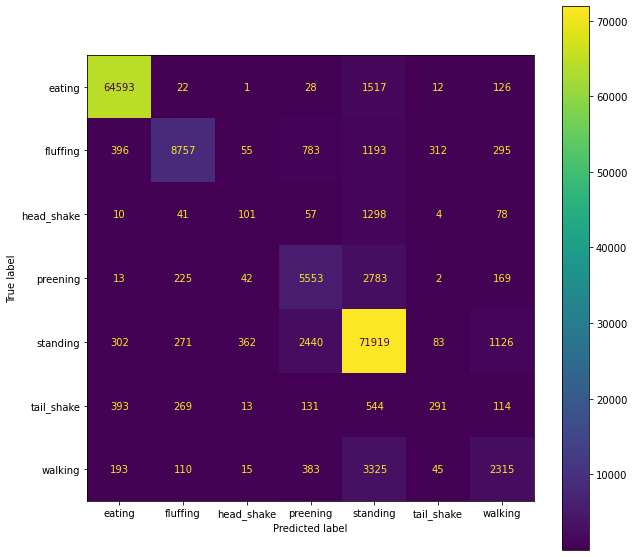

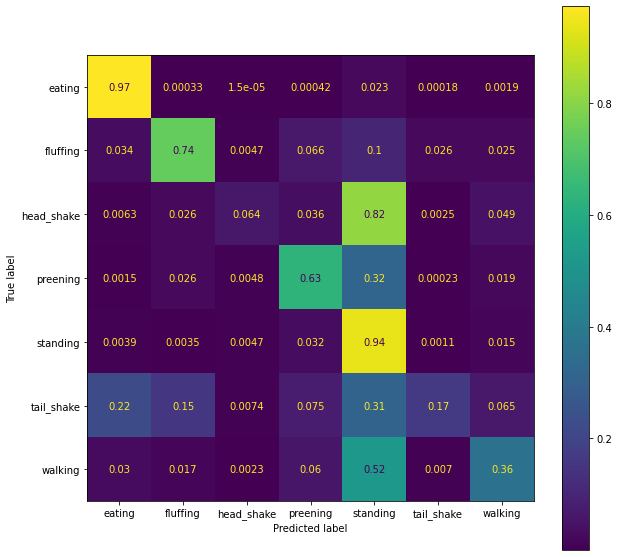

In [42]:
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, x_test, y_test, ax=ax) 

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, x_test, y_test, ax=ax, normalize='true') 

### RandomForest for 64 frames

In [47]:
x_ts, y_ts = create_ts(64, df)

loaded existing timeseries data for window size 64


In [48]:
x_train, x_valid, y_train, y_valid = train_test_split(x_ts, y_ts, test_size = 0.2, shuffle=False)

In [49]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, class_weight='balanced')
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=20, n_jobs=-1)

              precision    recall  f1-score   support

      eating       0.98      0.97      0.98     66299
    fluffing       0.90      0.64      0.75     11791
  head_shake       0.11      0.02      0.03      1589
    preening       0.55      0.64      0.59      8787
    standing       0.86      0.94      0.90     76490
  tail_shake       0.53      0.05      0.08      1755
     walking       0.54      0.30      0.39      6386

    accuracy                           0.88    173097
   macro avg       0.64      0.51      0.53    173097
weighted avg       0.87      0.88      0.87    173097



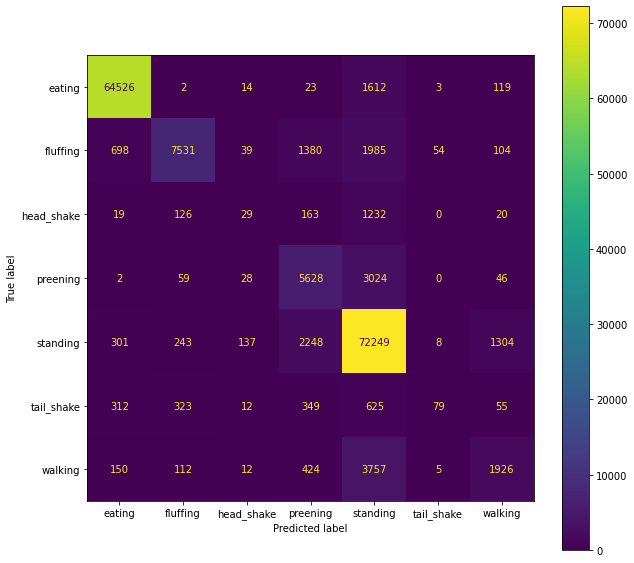

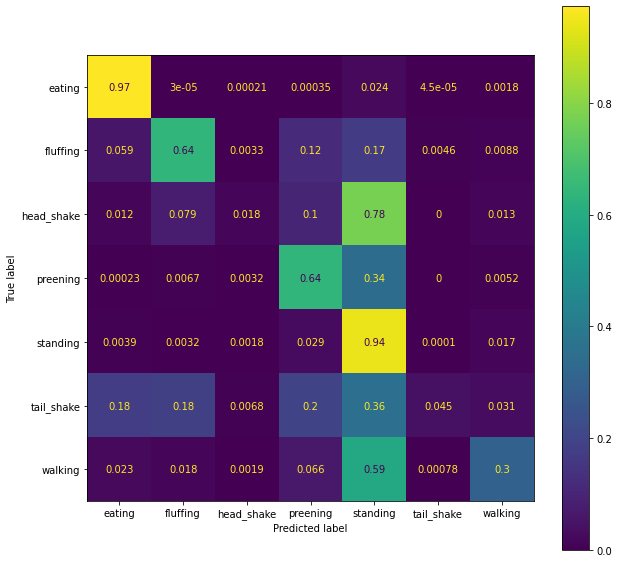

In [52]:
predictions = rf.predict(x_valid)
print(classification_report(y_valid, predictions))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, x_valid, y_valid, ax=ax) 

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, x_valid, y_valid, ax=ax, normalize='true') 

### RandomForest for 16 frames

loaded existing timeseries data for window size 16
              precision    recall  f1-score   support

      eating       0.98      0.97      0.98     66299
    fluffing       0.93      0.72      0.81     11791
  head_shake       0.19      0.04      0.07      1589
    preening       0.61      0.67      0.64      8787
    standing       0.86      0.94      0.90     76500
  tail_shake       0.53      0.16      0.24      1755
     walking       0.49      0.32      0.39      6386

    accuracy                           0.88    173107
   macro avg       0.66      0.55      0.58    173107
weighted avg       0.88      0.88      0.88    173107



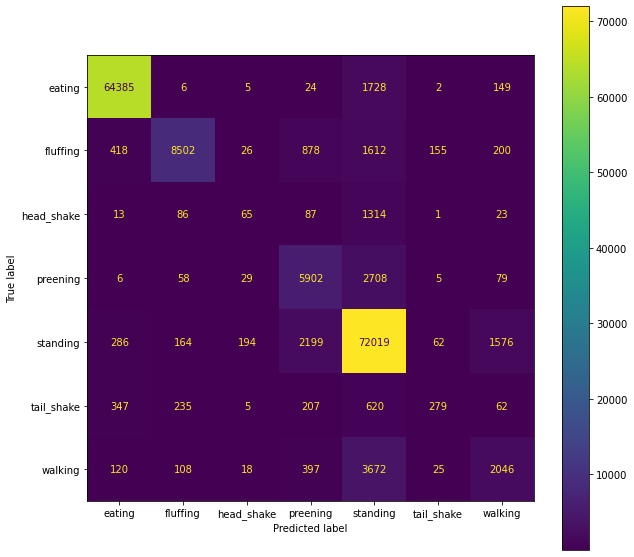

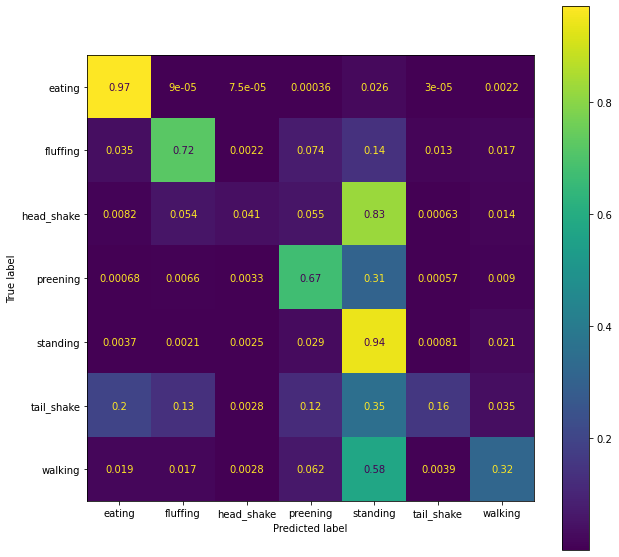

In [53]:
x_ts, y_ts = create_ts(16, df)
x_train, x_valid, y_train, y_valid = train_test_split(x_ts, y_ts, test_size = 0.2, shuffle=False)

rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, class_weight='balanced')
rf.fit(x_train, y_train)

predictions = rf.predict(x_valid)
print(classification_report(y_valid, predictions))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, x_valid, y_valid, ax=ax) 

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, x_valid, y_valid, ax=ax, normalize='true') 